In [1]:
from matplotlib.pylab import gca, figure, plot, subplot, title, xlabel, ylabel, xlim,show
from matplotlib.lines import Line2D
import src.segment as segment
import src.fit as fit
import matplotlib.pyplot as plt
import pandas as pd
import random
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tsfresh
from tsfresh.feature_extraction.settings import ComprehensiveFCParameters, MinimalFCParameters

# Paramter

In [3]:
RELOAD_DATA = True
DATA_PATH = "data/"

## Draw

In [4]:
def draw_plot(data,plot_title):
    plot(range(len(data)),data,alpha=0.8,color='red')
    title(plot_title)
    xlabel("Samples")
    ylabel("Signal")
    xlim((0,len(data)-1))

def draw_segments(segments):
    ax = gca()
    for segment in segments:
        line = Line2D((segment[0],segment[2]),(segment[1],segment[3]))
        ax.add_line(line)

def draw_xvline(segments):
    for seg in segments:
        x0 = seg[0]
        plt.axvline(x=x0)
        
def draw_approximate_line(ax_set):
    fig, axs = plt.subplots(1,1, figsize=(25, 5))
    x0,y0,x1,y1 = ax_set[0]
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for ax in ax_set:
        axs.plot((x1,ax[0]),(y1,ax[1]),ls='--',color='black',alpha=0.5)
        x0,y0,x1,y1 = ax
        axs.plot((x0,x1),(y0,y1),alpha=1,color=random.choice(colors))
    plt.show();

## Metrics

In [5]:
def get_anomaly_segment(line_segments):
    distance = [line_segments[0][3] - line_segments[1][1]]
    for i in range(1,len(line_segments)-1):
        left_distance = line_segments[i][1] - line_segments[i-1][3]
        right_distance = line_segments[i][3] - line_segments[i+1][1]
        dis = abs(left_distance + right_distance)
        distance.append(dis)
    last_dis = line_segments[len(line_segments)-1][1] - line_segments[len(line_segments)-2][3]
    distance.append(last_dis)
    return line_segments[distance.index(max(distance))]
def metrics(data,attack_indx,anomaly_segment):
    predict_index = np.arange(anomaly_segment[0],anomaly_segment[2],1)
    
    attack = np.zeros(data.shape[0])
    pred = np.zeros(data.shape[0])
    attack[attack_indx] = 1
    pred[predict_index] = 1
    
    tp = sum((a == 1 and p == 1) for a, p in zip(attack, pred))
    fp = sum((a == 0 and p == 1) for a, p in zip(attack, pred))
    fn = sum((a == 1 and p == 0) for a, p in zip(attack, pred))
    tn = sum((a == 0 and p == 0) for a, p in zip(attack, pred))
    
    accuracy = (tp + tn) / len(attack)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return accuracy,precision,recall,f1

# Data

In [6]:
SWaT_2019_df = pd.read_pickle(DATA_PATH + "swat_2019_attack_df.pkl")

In [7]:
SWaT_2019_df

,FIT 401,LIT 301,P601 Status,MV201,P101 Status,MV 501,P301 Status,Timestamps
0,0.781740,730.702100,1,2,2,2,1,2019-07-20 04:30:00.000000000
1,0.782380,730.902344,1,2,2,2,1,2019-07-20 04:30:01.000000000
2,0.783021,732.344300,1,2,2,2,1,2019-07-20 04:30:02.004013000
3,0.783021,732.704800,1,2,2,2,1,2019-07-20 04:30:03.004013000
4,0.781228,732.744800,1,2,2,2,1,2019-07-20 04:30:04.000000000
...,...,...,...,...,...,...,...,...
14991,0.809271,883.227051,1,2,2,2,2,2019-07-20 08:39:55.001007000
14992,0.809271,883.227051,1,2,2,2,2,2019-07-20 08:39:56.005004800
14993,0.809271,883.387268,1,2,2,2,2,2019-07-20 08:39:57.005004800
14994,0.808631,883.908000,1,2,2,2,2,2019-07-20 08:39:58.005004800


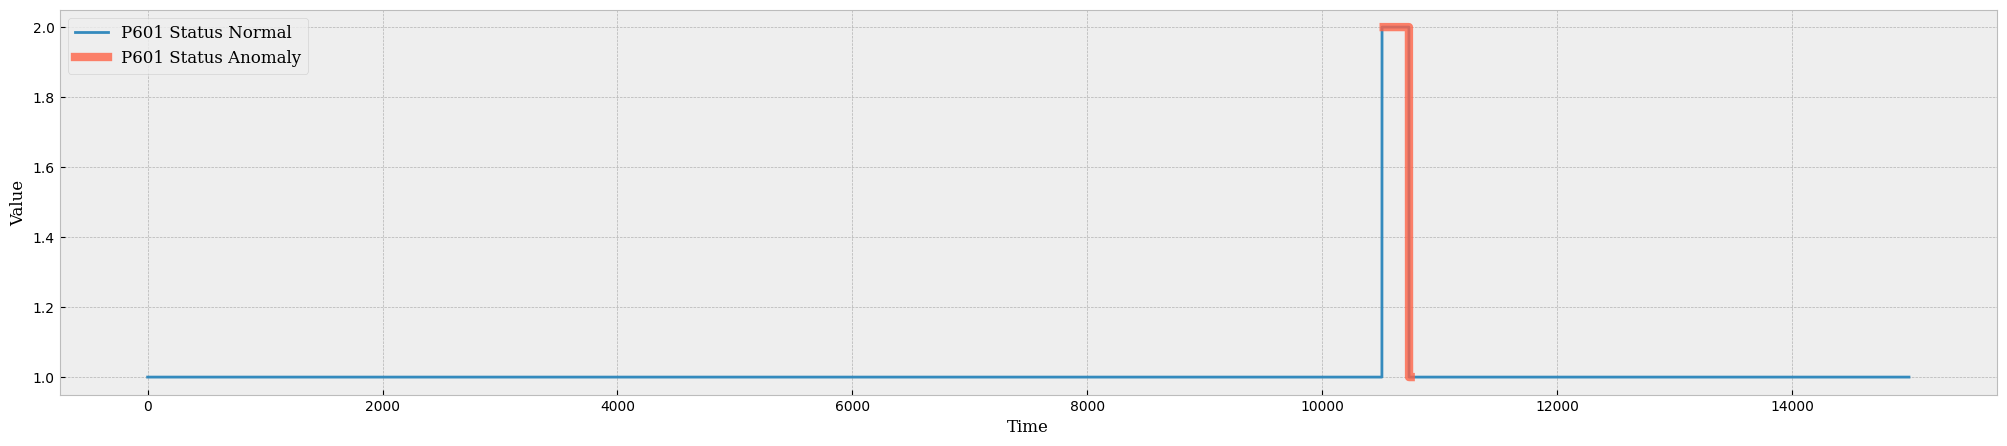

In [8]:
anomaly_feature = 'P601 Status'
anomaly_time = [np.array('2019-07-20 07:25:27', dtype=np.datetime64),
                np.array('2019-07-20 07:29:18', dtype=np.datetime64)]

with plt.style.context('bmh'):
    font = {'size': 12, 'family': 'serif'}
    font_legend = {'size': 12, 'family': 'serif'}
    fig, axs = plt.subplots(1, 1, figsize=(25,5))
    
    start_attack_time = anomaly_time[0]
    end_attack_time = anomaly_time[1]
    attack_df = SWaT_2019_df[SWaT_2019_df["Timestamps"] >= start_attack_time]
    attack_df = attack_df[attack_df["Timestamps"] <= end_attack_time]
    attack_indx =list(attack_df.index)


    axs.plot(SWaT_2019_df[anomaly_feature],
             label='{} Normal'.format(anomaly_feature))
             
    axs.plot(SWaT_2019_df[anomaly_feature].loc[attack_indx],
             label='{} Anomaly'.format(anomaly_feature),
             color='tomato', 
             linewidth=6,
             alpha=0.8)
    axs.set_xlabel('Time', fontdict=font)
    axs.set_ylabel('Value', fontdict=font)
    axs.legend(loc='upper left', prop=font_legend)
    plt.show();

## Extract Features

In [9]:
ts = pd.DataFrame(SWaT_2019_df,columns=[anomaly_feature,'Timestamps'])
ts['id'] = 1

In [10]:
extracted_feature = tsfresh.extract_features(ts,column_id='id',column_sort='Timestamps',column_value=anomaly_feature)

Feature Extraction: 100%|███████████████████████████████████████████████████████████████| 1/1 [02:47<00:00, 167.88s/it]


In [11]:
extracted_relevant_feature = pd.DataFrame(extracted_feature,columns=[f'{anomaly_feature}__mean',
                                                                     f'{anomaly_feature}__median',
                                                                     f'{anomaly_feature}__variance',
                                                                     f'{anomaly_feature}__standard_deviation',
                                                                     f'{anomaly_feature}__mean_change',
                                                                     f'{anomaly_feature}__kurtosis',
                                                                     f'{anomaly_feature}__minimum',
                                                                     f'{anomaly_feature}__maximum']).T
extracted_relevant_feature = extracted_relevant_feature.rename(columns={1: anomaly_feature})
extracted_relevant_feature.index = ['mean','median','variance','standard_deviation','mean_change',
                                      'kurtosis','minimum','maximum']

In [12]:
extracted_relevant_feature

,P601 Status
mean,1.015337
median,1.000000
variance,0.015102
standard_deviation,0.122891
mean_change,0.000000
kurtosis,60.236059
minimum,1.000000
maximum,2.000000


👉 Data có variance **thấp**

👉 kurtosis >> 3, mean_change << phân bố dữ liệu tập trung tại 1 điểm

# Top-down

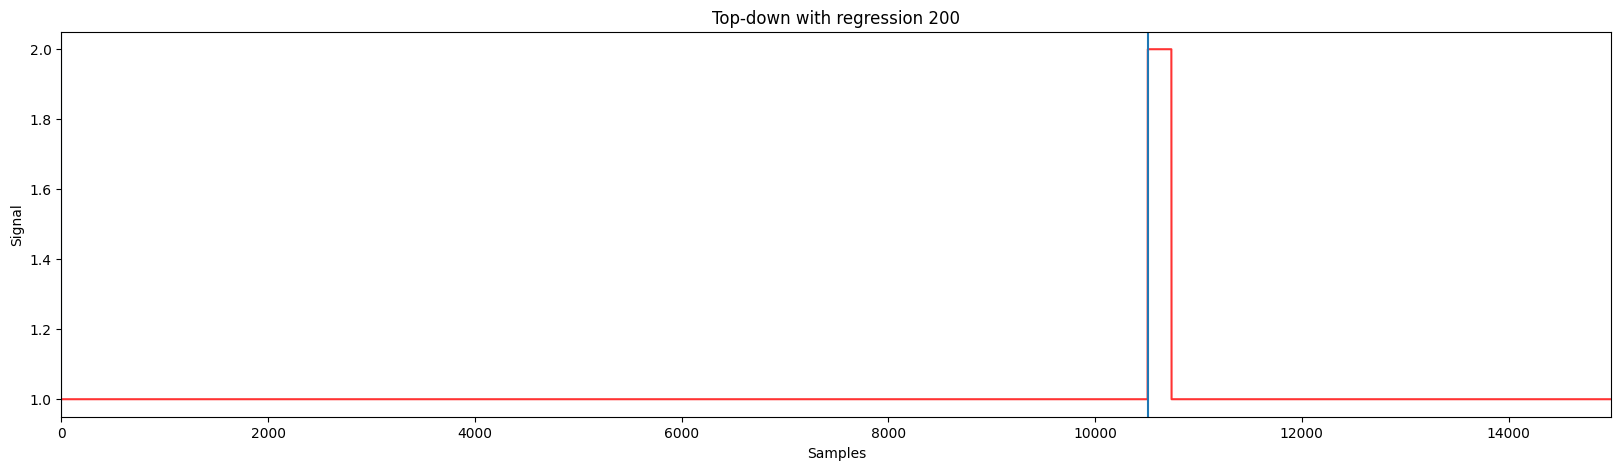

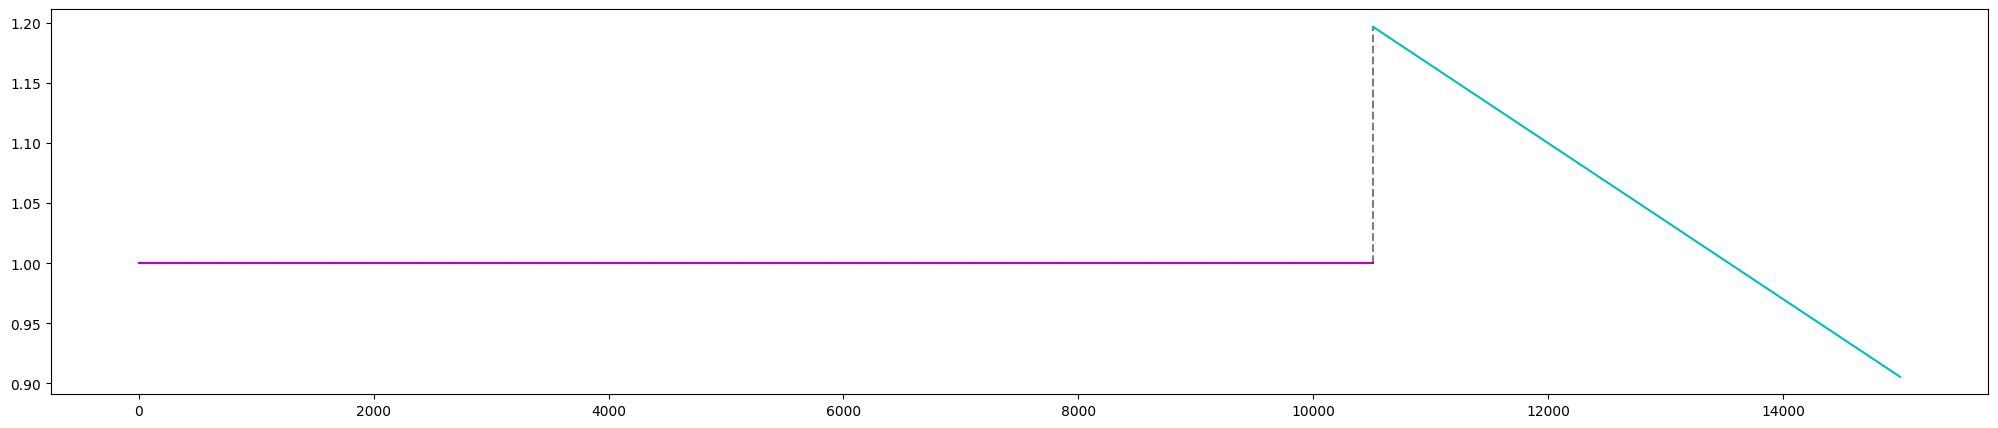

In [13]:
max_error = 200
data = list(SWaT_2019_df[anomaly_feature].values)
ts_segments, line_segments = segment.get_ts_segments(segment.topdownsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Top-down with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);

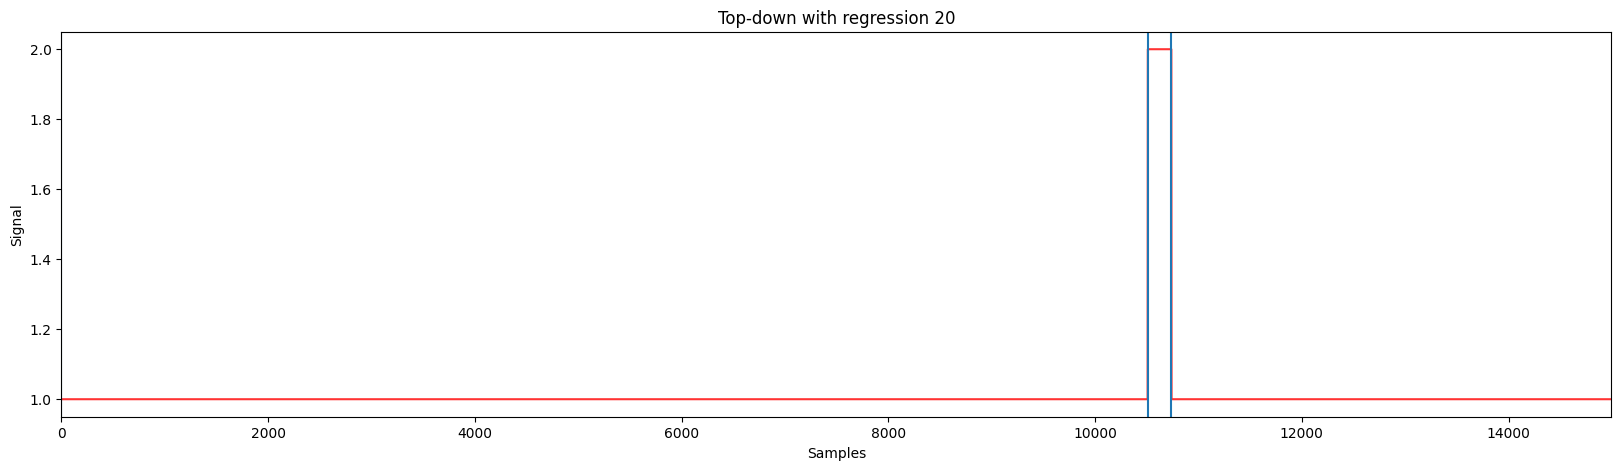

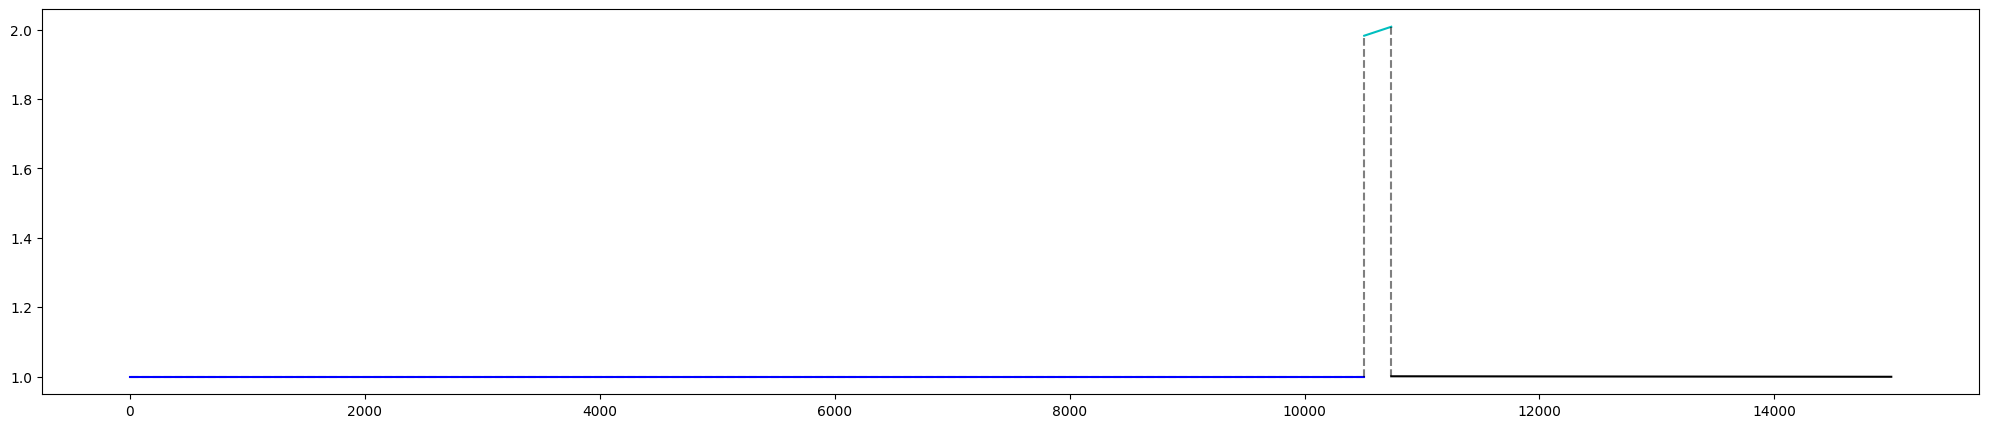

In [34]:
max_error = 20
data = list(SWaT_2019_df[anomaly_feature].values)
ts_segments, line_segments = segment.get_ts_segments(segment.topdownsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Top-down with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);

## Best

<Figure size 2000x500 with 0 Axes>

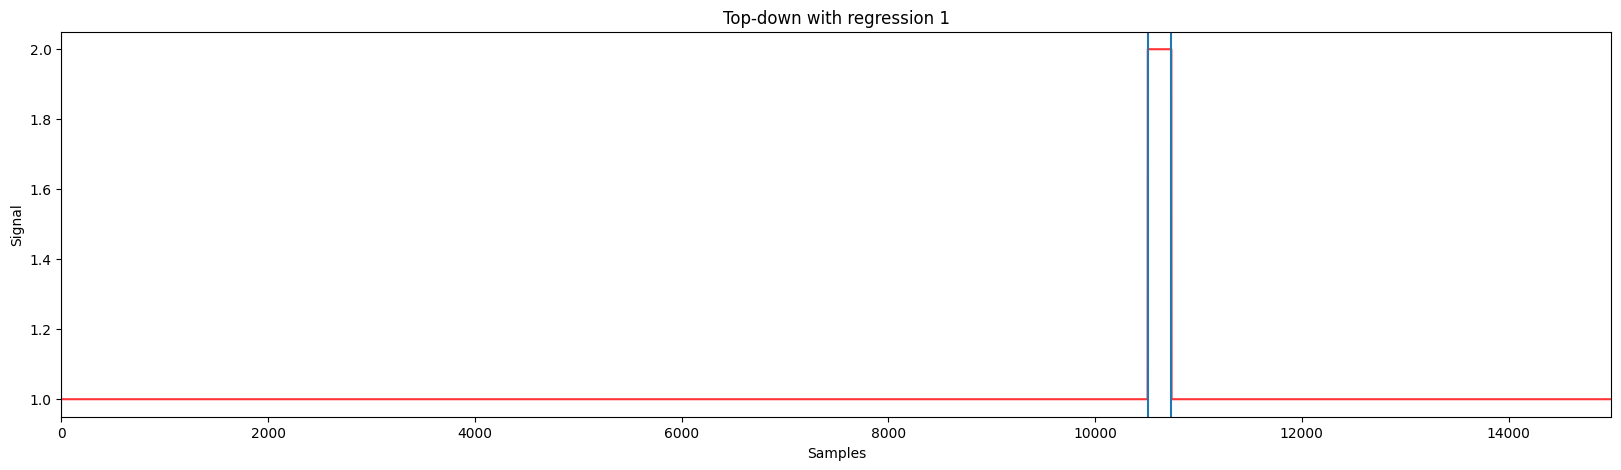

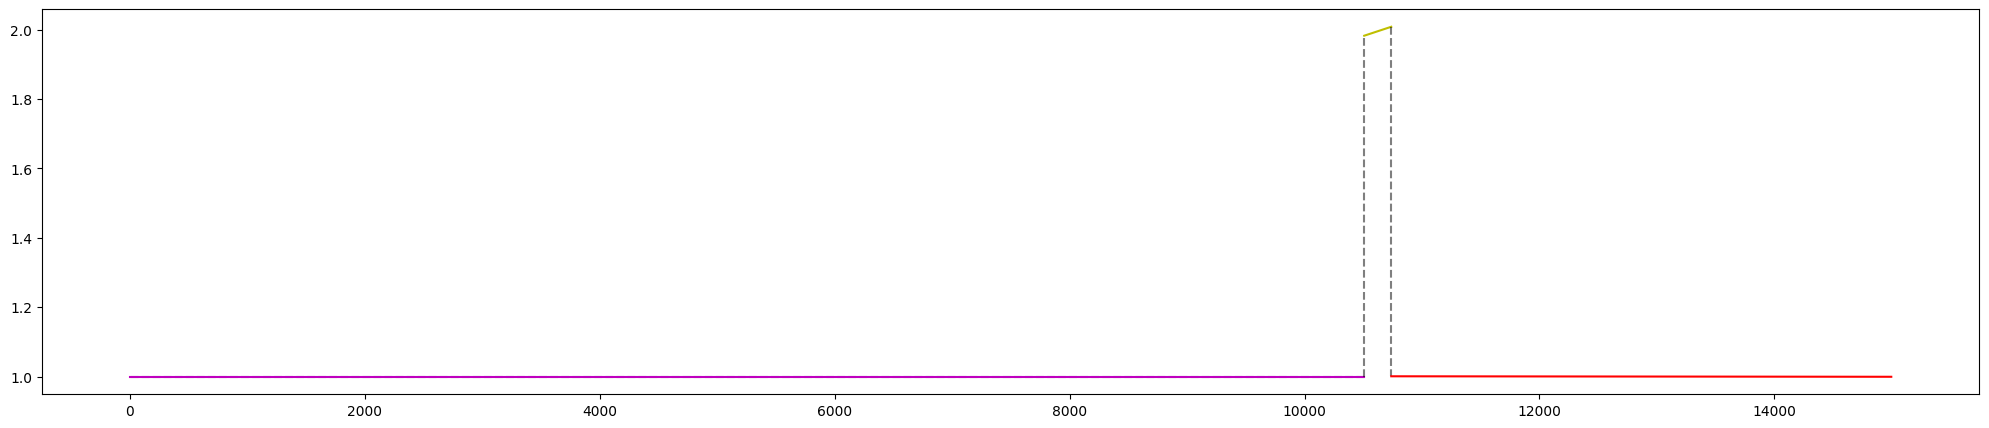

In [14]:
max_error = 1
data = list(SWaT_2019_df[anomaly_feature].values)
ts_segments, line_segments = segment.get_ts_segments(segment.topdownsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Top-down with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);

In [15]:
anomaly_segment = get_anomaly_segment(line_segments)
acc_topdown,pre_topdown,recall_topdown,f1_topdown = metrics(SWaT_2019_df,attack_indx,anomaly_segment)

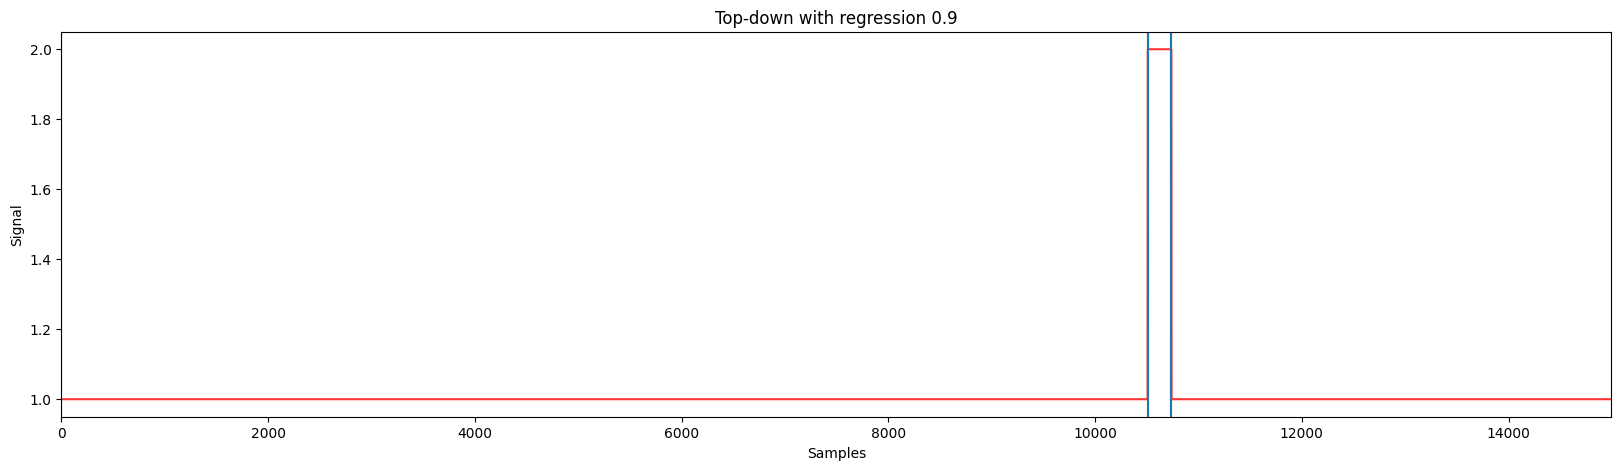

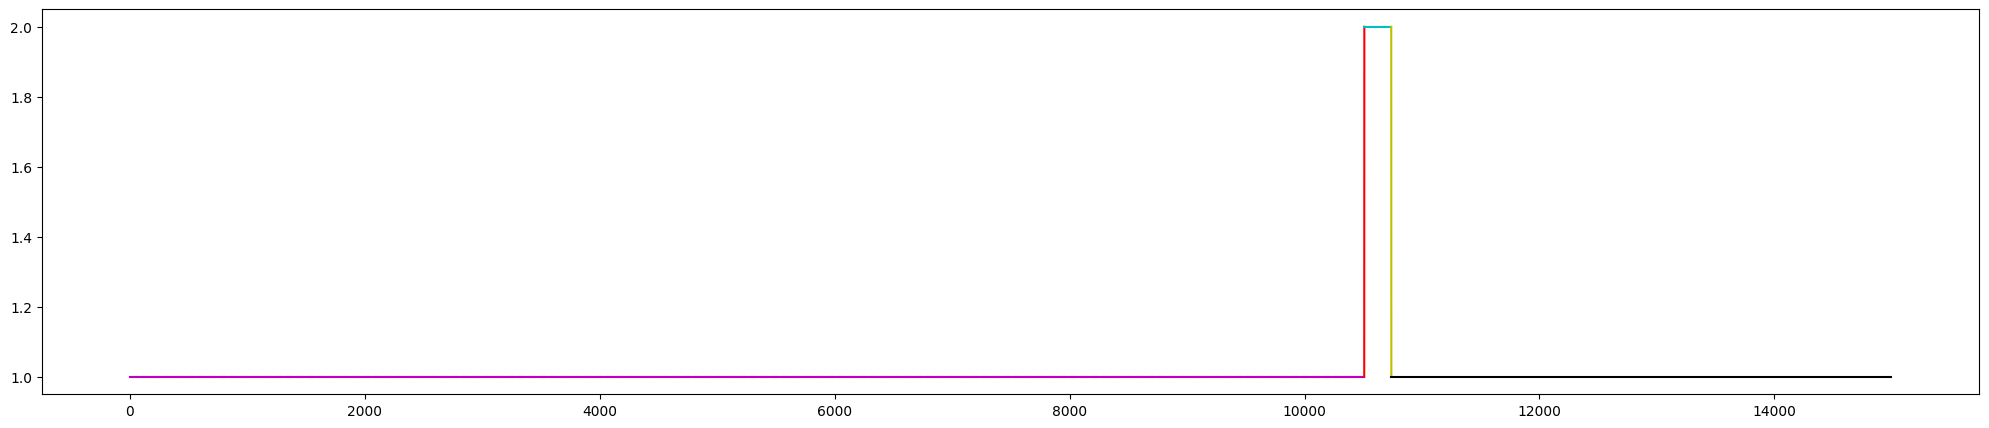

In [26]:
max_error = 0.9
data = list(SWaT_2019_df[anomaly_feature].values)
ts_segments, line_segments = segment.get_ts_segments(segment.topdownsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Top-down with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);

👉 range (1,100)

# Bottom-up

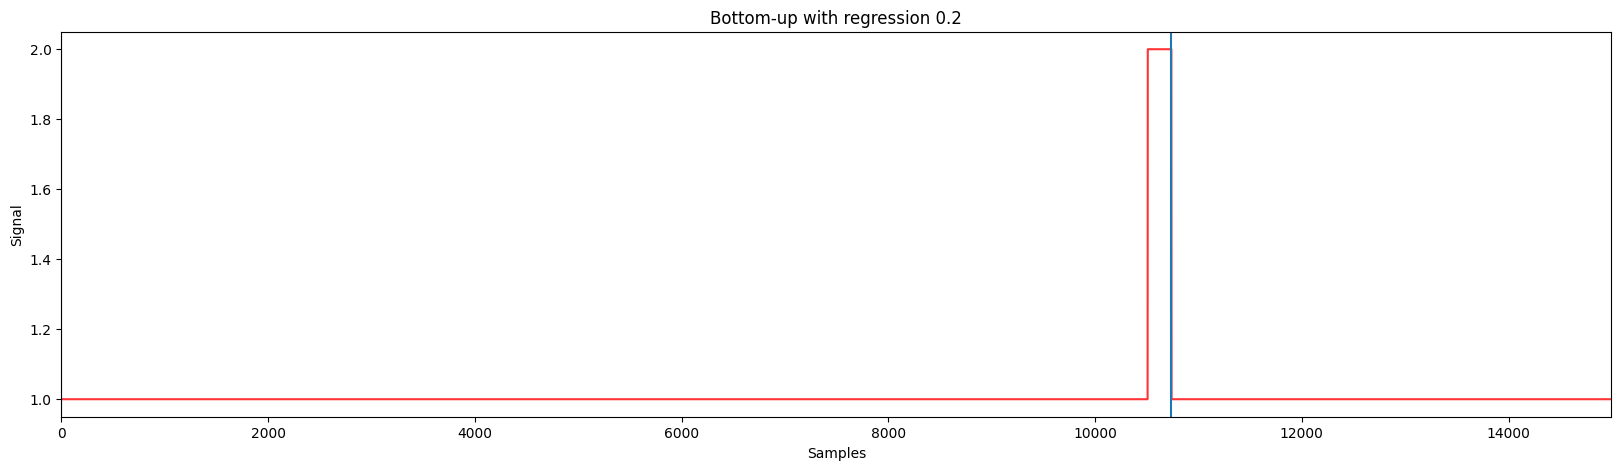

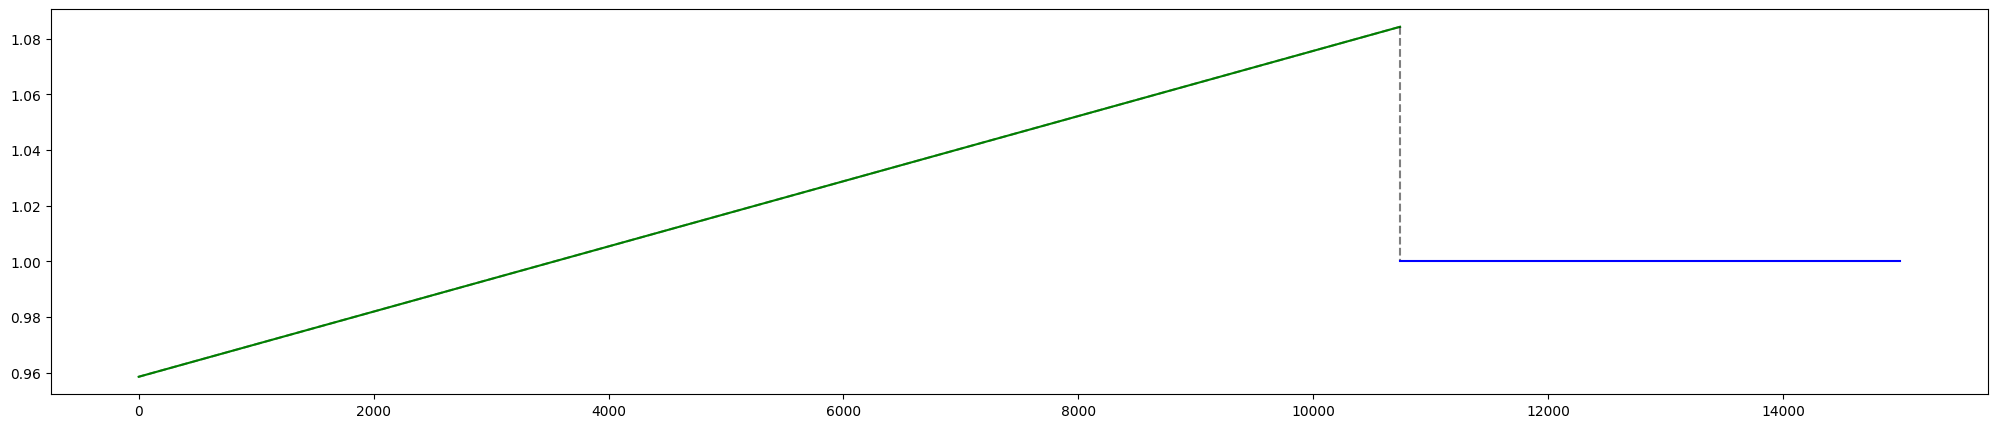

In [34]:
max_error = 1
data = list(SWaT_2019_df[anomaly_feature].values)
ts_segments, line_segments = segment.get_ts_segments(segment.bottomupsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,"Bottom-up with regression 0.2")
draw_xvline(line_segments)
draw_approximate_line(line_segments);

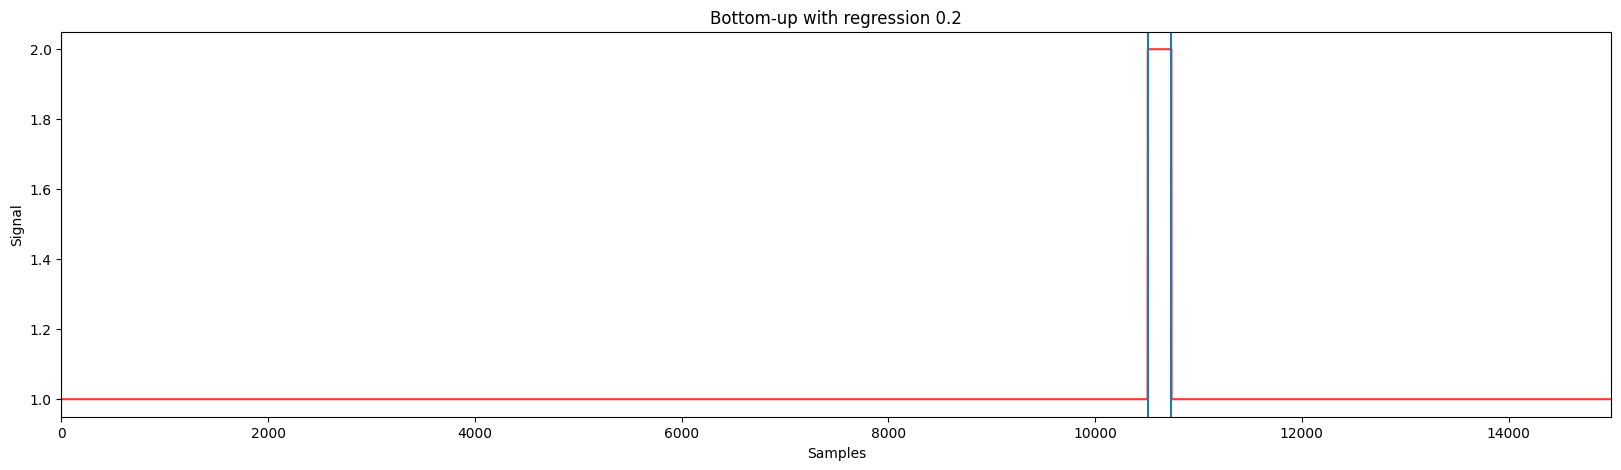

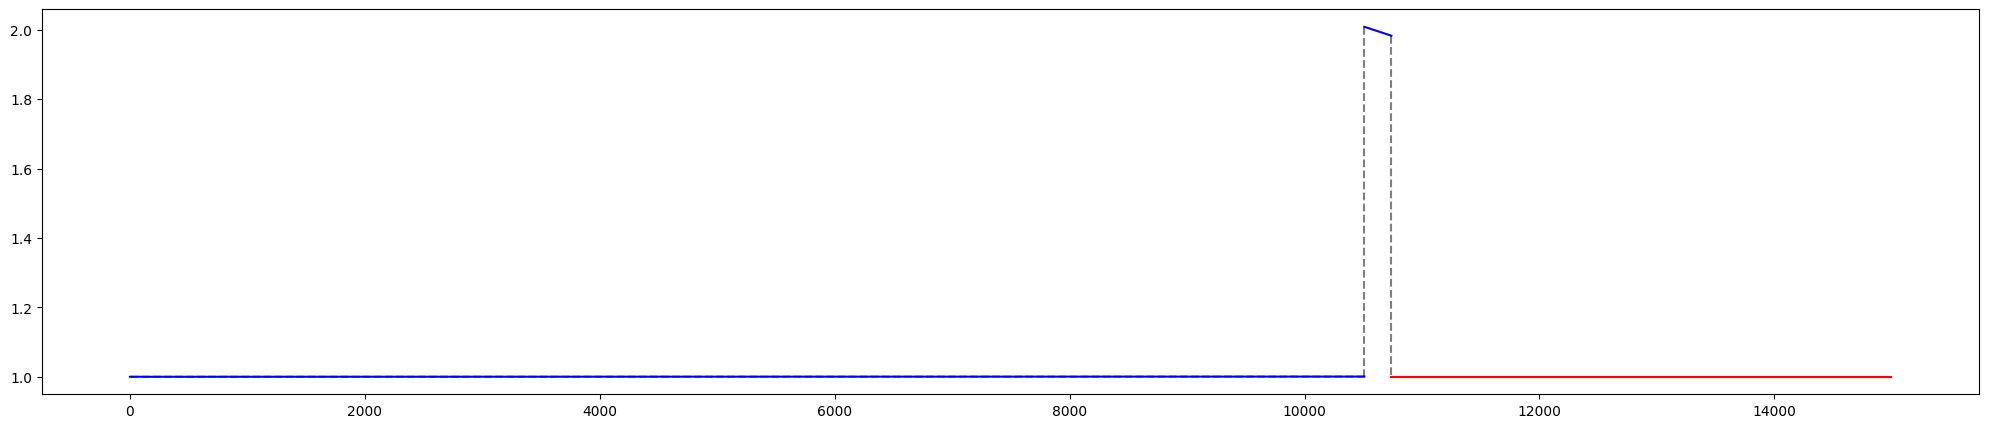

In [17]:
max_error = 0.9
data = list(SWaT_2019_df[anomaly_feature].values)
ts_segments, line_segments = segment.get_ts_segments(segment.bottomupsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,"Bottom-up with regression 0.2")
draw_xvline(line_segments)
draw_approximate_line(line_segments);

In [18]:
anomaly_segment = get_anomaly_segment(line_segments)
acc_btu,pre_btu,recall_btu,f1_btu = metrics(SWaT_2019_df,attack_indx,anomaly_segment)
acc_btu,pre_btu,recall_btu,f1_btu

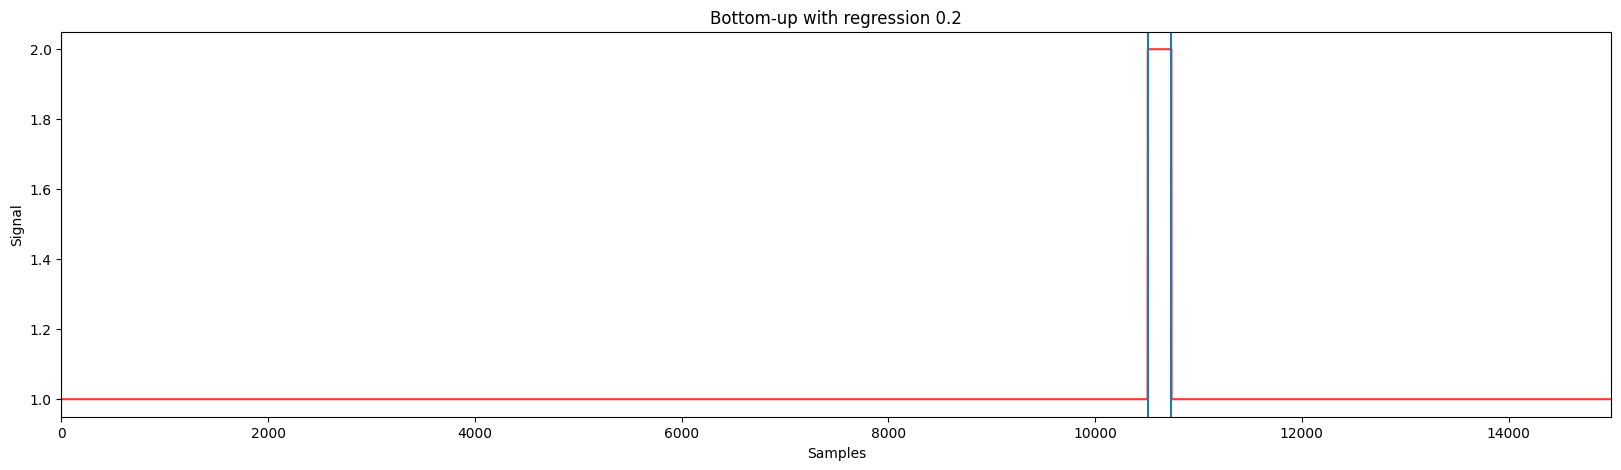

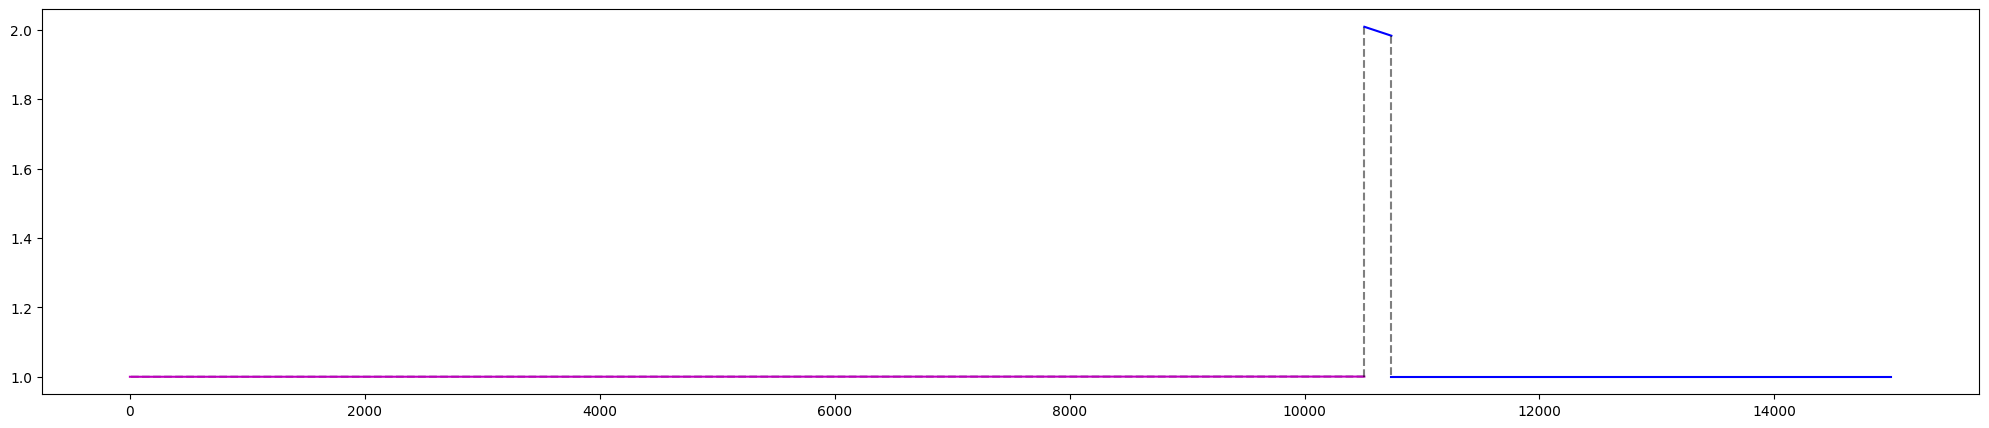

In [21]:
max_error = 0.5
data = list(SWaT_2019_df[anomaly_feature].values)
ts_segments, line_segments = segment.get_ts_segments(segment.bottomupsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,"Bottom-up with regression 0.2")
draw_xvline(line_segments)
draw_approximate_line(line_segments);

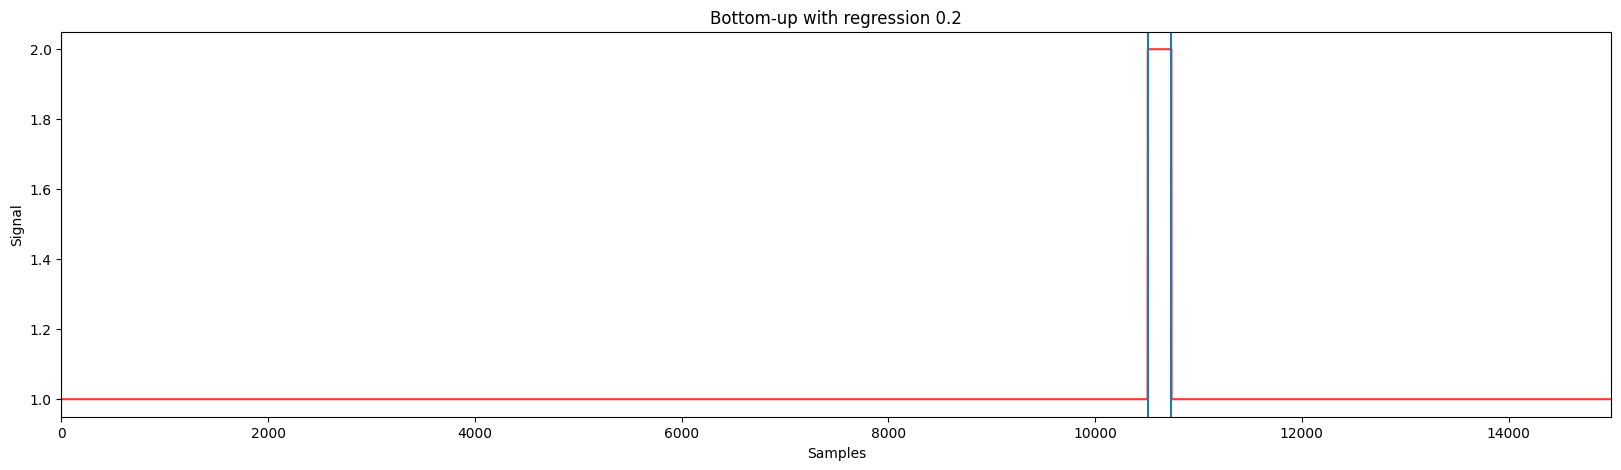

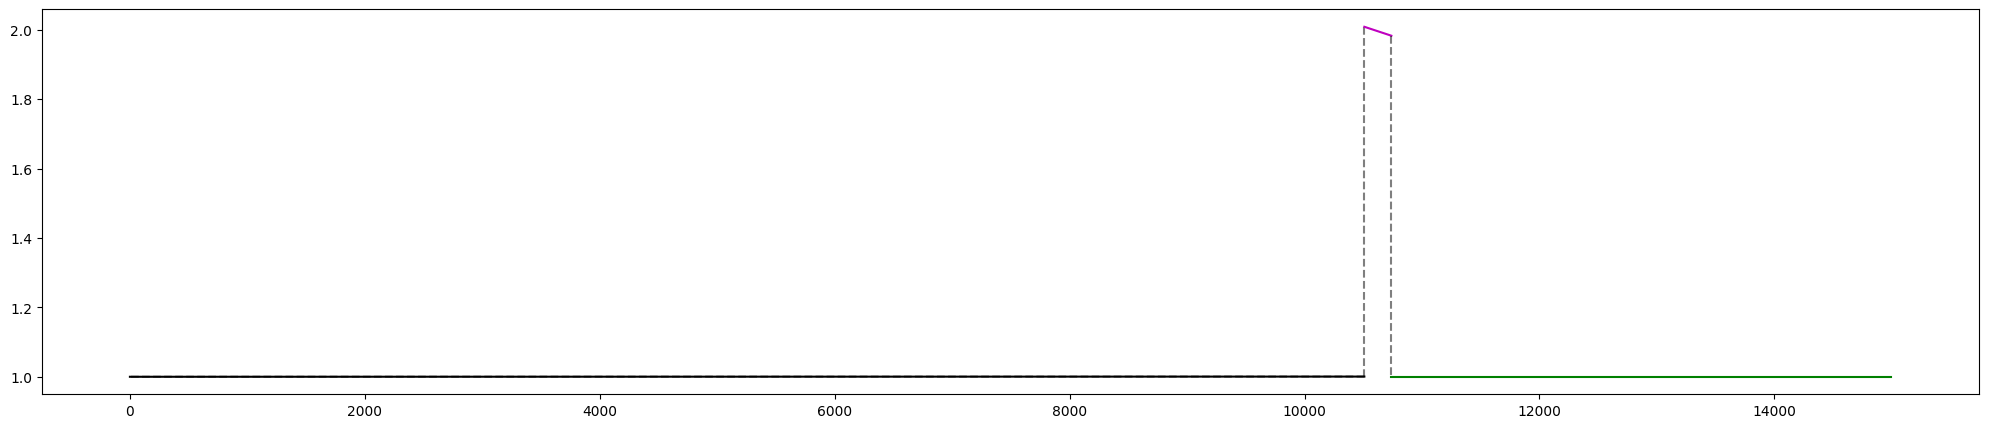

In [40]:
max_error = 0.0001
data = list(SWaT_2019_df[anomaly_feature].values)
ts_segments, line_segments = segment.get_ts_segments(segment.bottomupsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,"Bottom-up with regression 0.2")
draw_xvline(line_segments)
draw_approximate_line(line_segments);

👉 range (0,0.9)

# Sliding Window

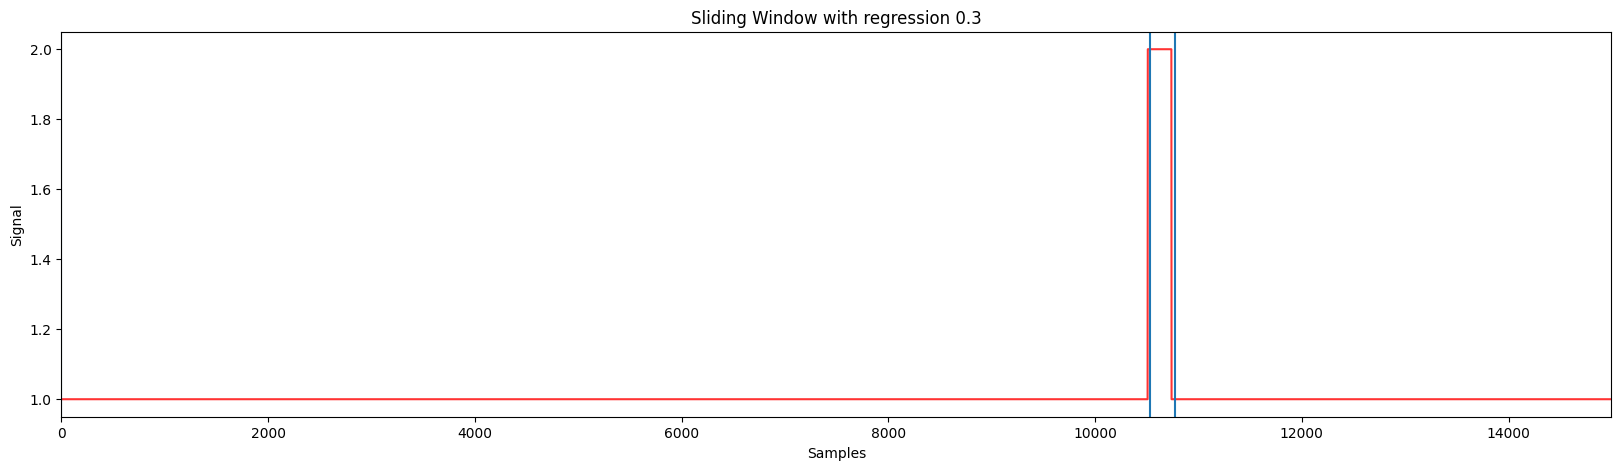

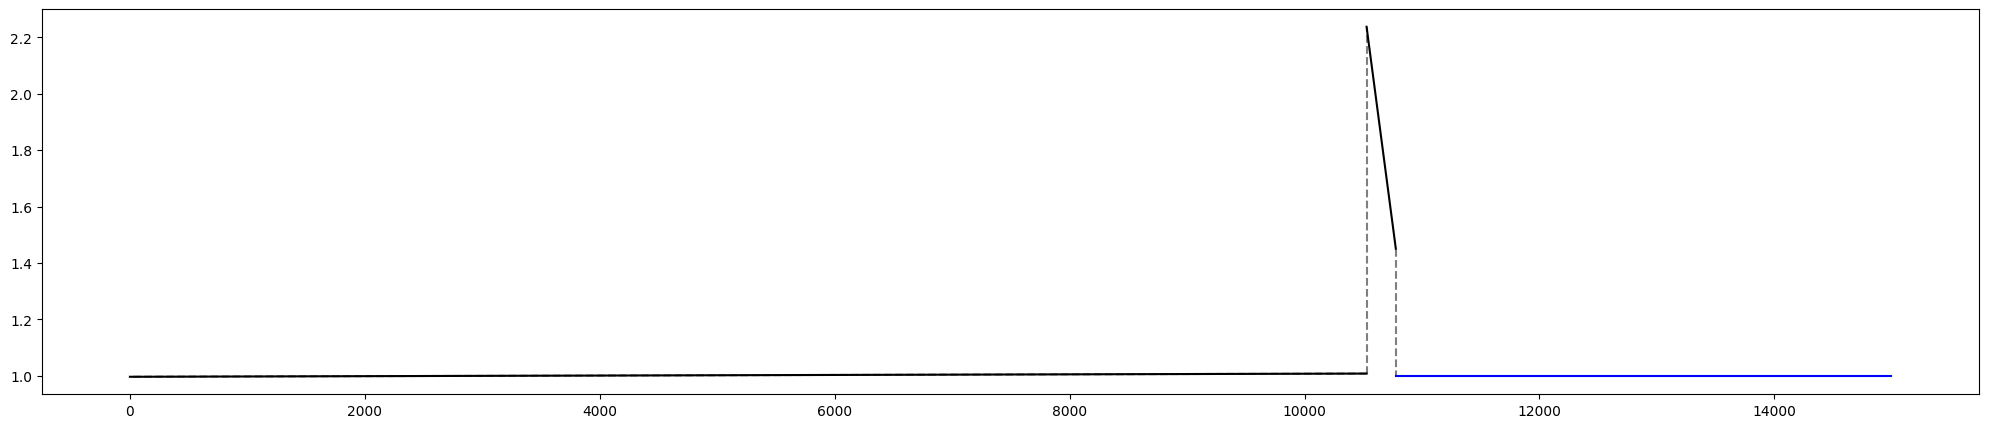

In [28]:
max_error = 20
data = list(SWaT_2019_df[anomaly_feature].values)
ts_segments, line_segments = segment.get_ts_segments(segment.slidingwindowsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,"Sliding Window with regression 0.3")
draw_xvline(line_segments)
draw_approximate_line(line_segments);

## Best

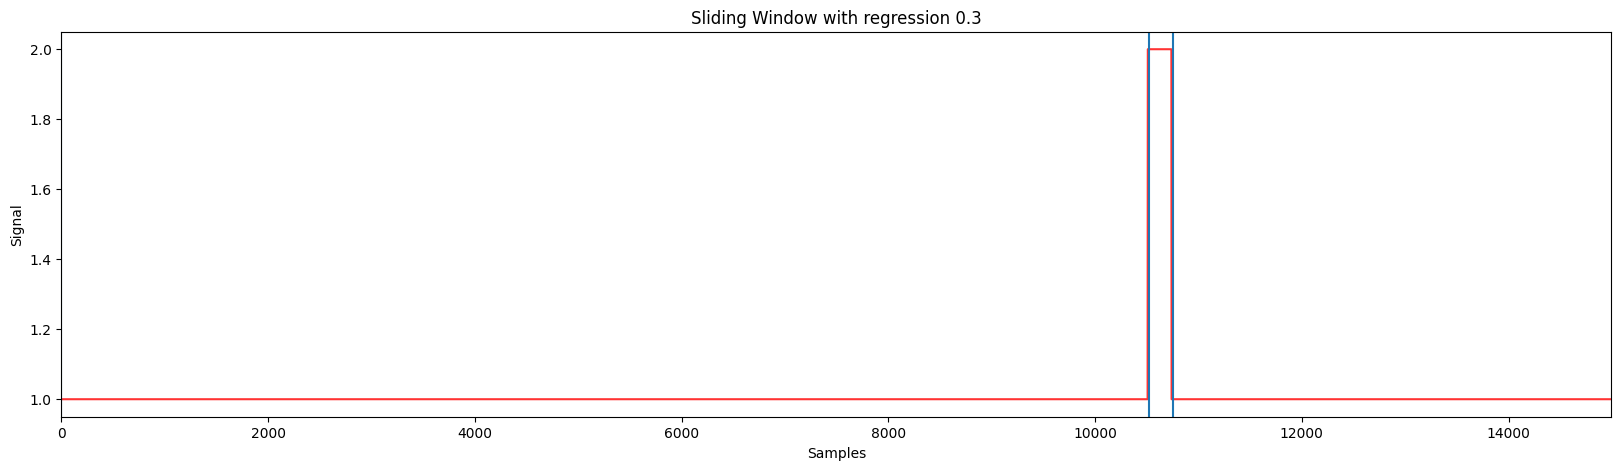

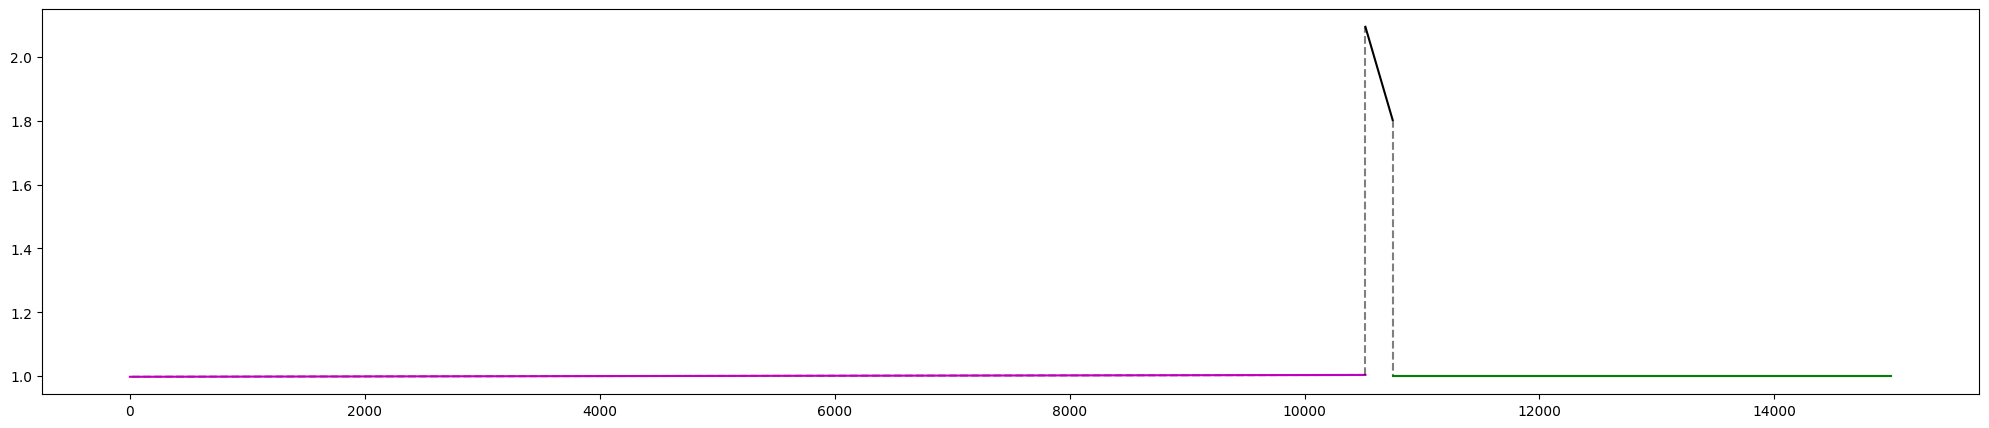

In [30]:
max_error = 10
data = list(SWaT_2019_df[anomaly_feature].values)
ts_segments, line_segments = segment.get_ts_segments(segment.slidingwindowsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,"Sliding Window with regression 0.3")
draw_xvline(line_segments)
draw_approximate_line(line_segments);

In [31]:
anomaly_segment = get_anomaly_segment(line_segments)
acc_sldw,pre_sldw,recall_sldw,f1_sldw = metrics(SWaT_2019_df,attack_indx,anomaly_segment)
acc_sldw,pre_sldw,recall_sldw,f1_sldw

(0.999399839957322, 0.978448275862069, 0.9826839826839827, 0.980561555075594)

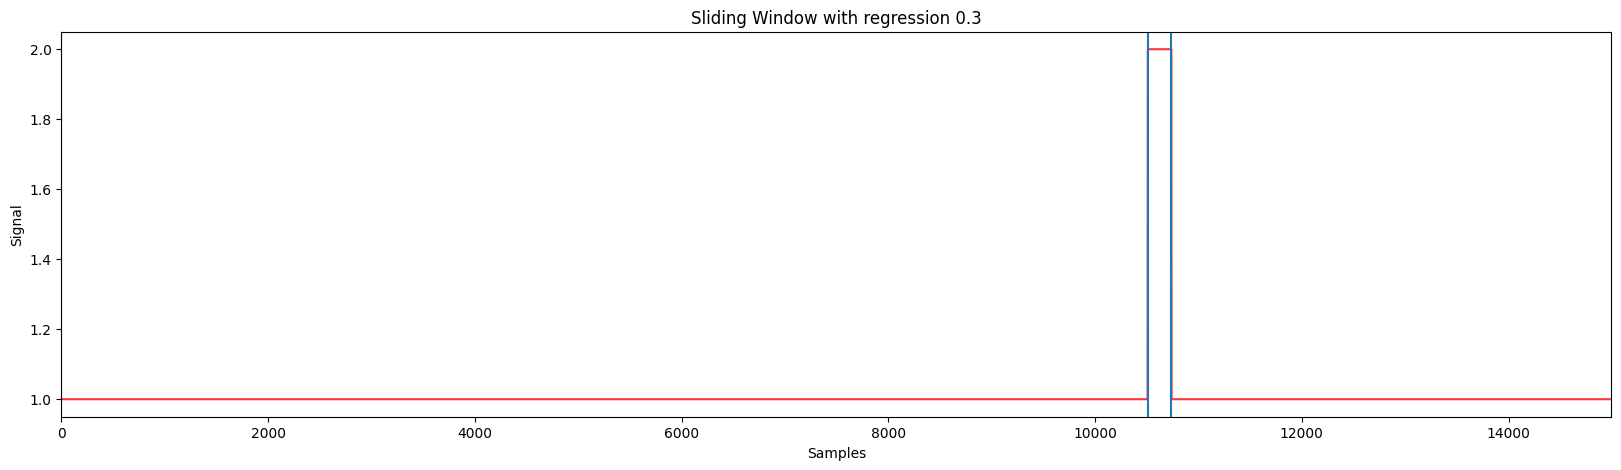

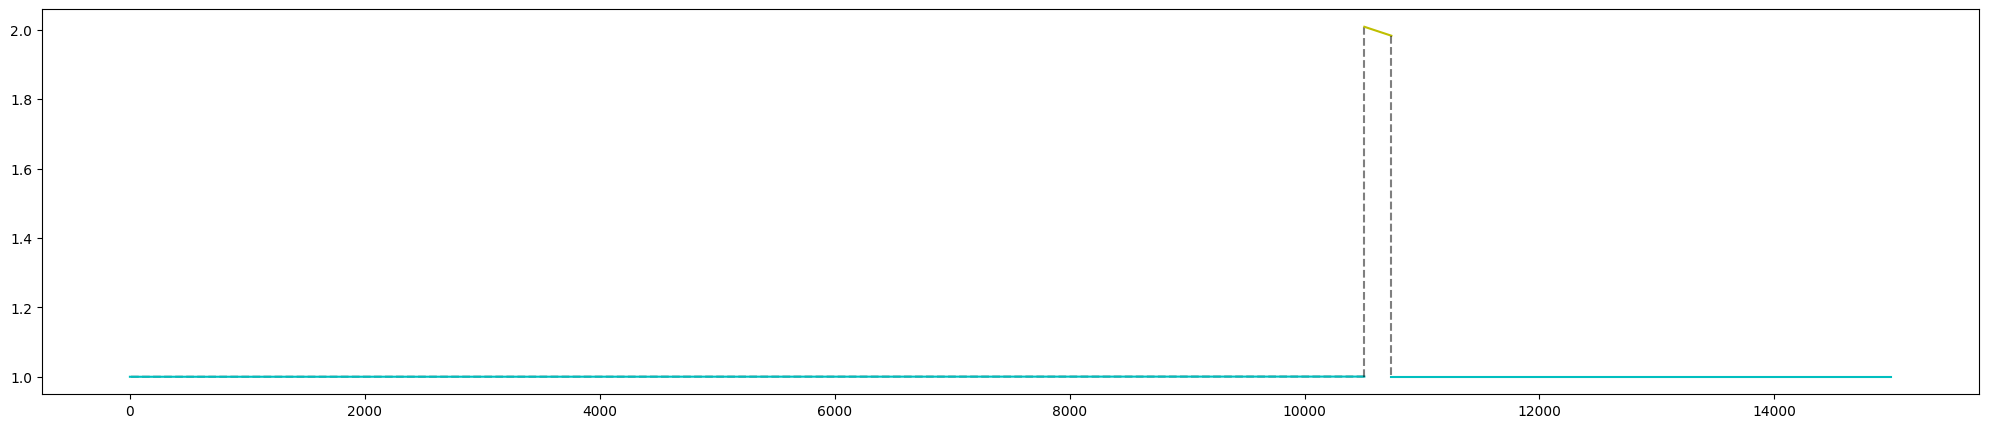

In [41]:
max_error = 1
data = list(SWaT_2019_df[anomaly_feature].values)
ts_segments, line_segments = segment.get_ts_segments(segment.slidingwindowsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,"Sliding Window with regression 0.3")
draw_xvline(line_segments)
draw_approximate_line(line_segments);

👉 Range = (0.5;20)

# SWAB

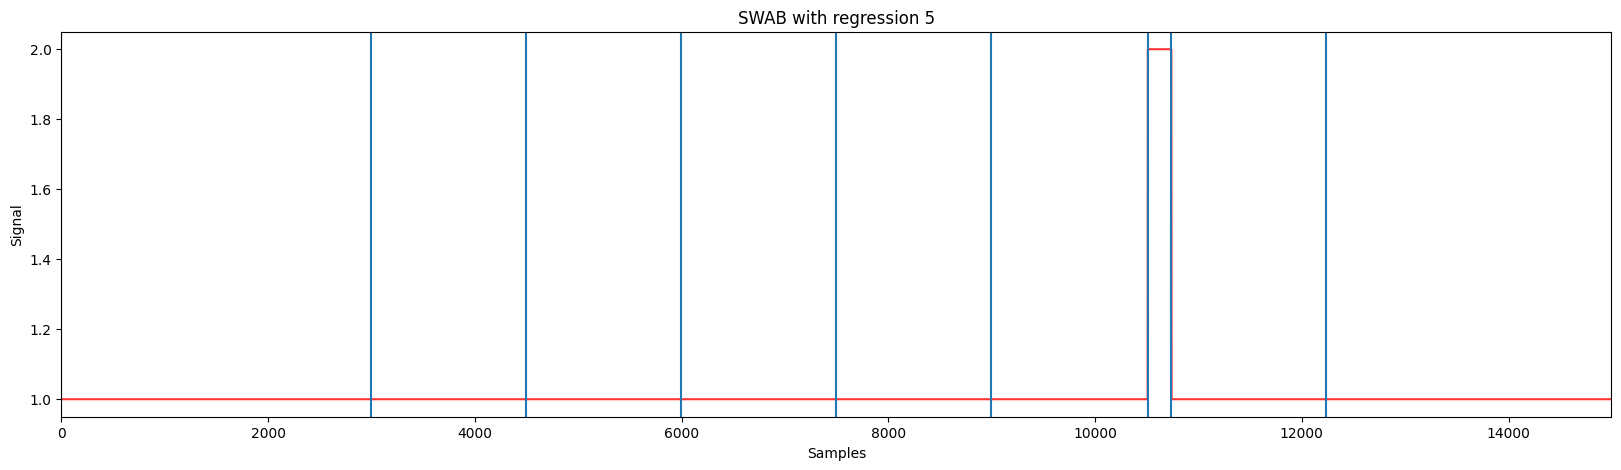

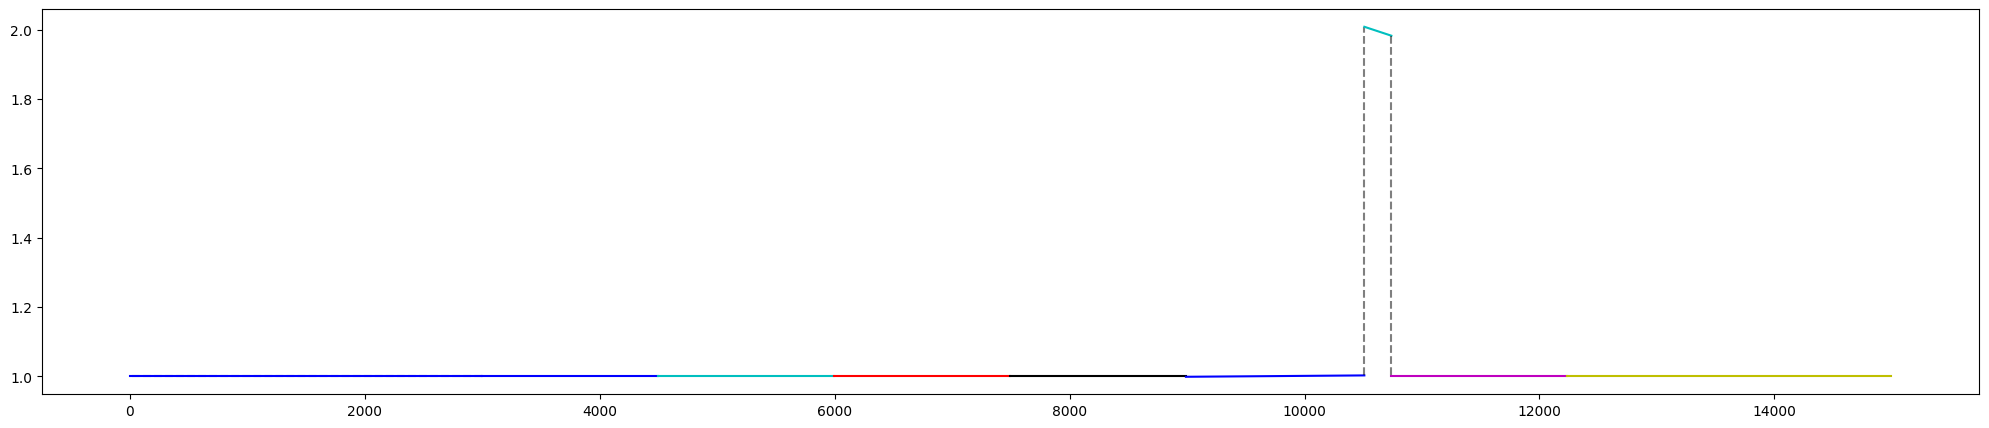

In [37]:
max_error = 5
data = list(SWaT_2019_df[anomaly_feature].values)
ts_segments, line_segments = segment.get_ts_segments(segment.SWABsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"SWAB with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);

In [50]:
anomaly_segment = get_anomaly_segment(line_segments)
acc_swab,pre_swab,recall_swab,f1_swab = metrics(SWaT_2019_df,attack_indx,anomaly_segment)
acc_swab,pre_swab,recall_swab,f1_swab

(0.998066150973593, 0.9391304347826087, 0.935064935064935, 0.9370932754880694)

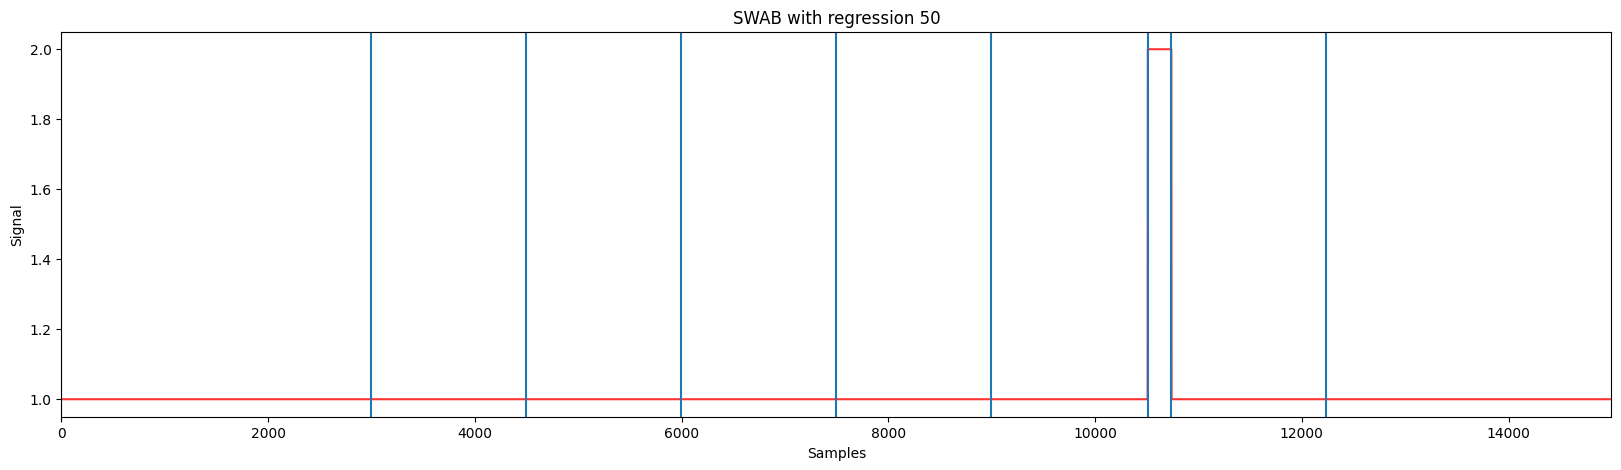

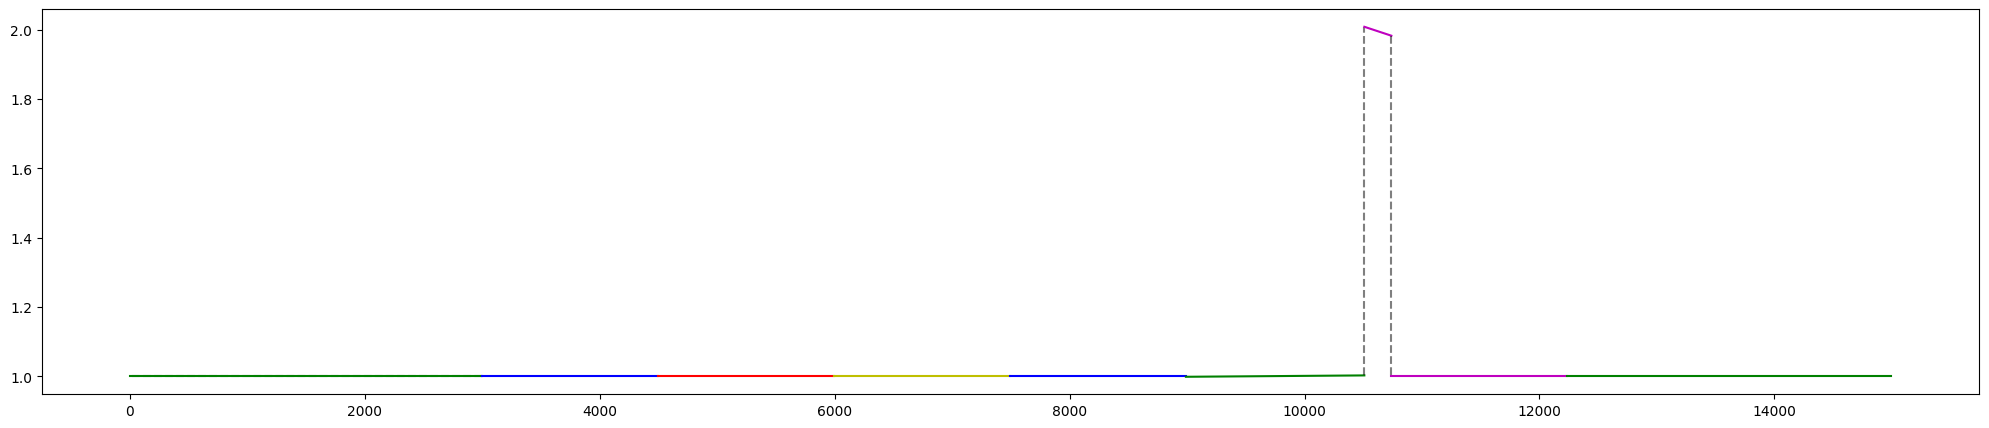

In [49]:
max_error = 50
data = list(SWaT_2019_df[anomaly_feature].values)
ts_segments, line_segments = segment.get_ts_segments(segment.SWABsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"SWAB with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);

# Conclusion

In [53]:
range_Top_down = [1,100]
range_Bottom_up = [0,0.9]
range_sliding_window = [0.5,20]
range_swab = [5,50]


time_avg_Top_down = 35
time_avg_Bottom_up = 11.725
time_avg_sliding_window = 9.75
time_avg_swab = 16.2


best_Top_down = 1
best_Bottom_up = 'All'
best_sliding_window = 1
best_swab =  5


In [55]:
data = {
    'Algorithm': ['Top-down', 'Bottom-up', 'Sliding-window','SWAB'],
    'min': [range_Top_down[0],range_Bottom_up[0], range_sliding_window[0],range_swab[0]],
    'max': [range_Top_down[1],range_Bottom_up[1],range_sliding_window[1],range_swab[1]],
    'Best': [best_Top_down, best_Bottom_up,best_sliding_window,best_swab],
    'Time Average(s)': [time_avg_Top_down, time_avg_Bottom_up, time_avg_sliding_window,time_avg_swab],
    'Accuracy' : [acc_topdown,acc_btu,acc_sldw,acc_swab],
    'Precision' : [pre_topdown,pre_btu,pre_sldw,pre_swab],
    'Recall' : [recall_topdown,recall_btu,recall_sldw,recall_swab],
    'F1-score' : [f1_topdown,f1_btu,f1_sldw,f1_swab],
    'Rank' : [3,2,1,2]
}

conclusion_df = pd.DataFrame(data)
conclusion_df

,Algorithm,min,max,Best,Time Average(s),Accuracy,Precision,Recall,F1-score,Rank
0,Top-down,1.0,100.0,1,35.000,0.997933,0.934783,0.930736,0.932755,3
1,Bottom-up,0.0,0.9,All,11.725,0.998066,0.939130,0.935065,0.937093,2
2,Sliding-window,0.5,20.0,1,9.750,0.999400,0.978448,0.982684,0.980562,1
3,SWAB,5.0,50.0,5,16.200,0.998066,0.939130,0.935065,0.937093,2
